# Geometric Brownian Motion Demo

Geometric Brownian motion  is a continuous stochastic process in which the natural logarithm of its values follows a Brownian motion. 

Mathematically, it can be defined as follows:

$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$,

where $S_0$ is the initial value, $\mu$ and $\sigma$ are drift and difussion coefficients, respectively, and $W_t$ is a (Standard) Brownian motion.

GBM is commonly used to model stock prices and options payoffs. 

In [2]:
import qmcpy as qp
import numpy as np
import scipy.stats
import pandas as pd
import time
from matplotlib import pyplot
import matplotlib.pyplot as plt


# GMB object

In [10]:
gbm = qp.GeometricBrownianMotion(qp.Lattice(2)) 
gbm

GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.5 1. ]
    drift           0
    diffusion       1
    mean            [-0.25 -0.5 ]
    covariance      [[0.5 0.5]
                    [0.5 1. ]]
    mean_gbm        [1. 1.]
    covariance_gbm  [[0.649 0.649]
                    [0.649 1.718]]
    decomp_type     PCA

In [48]:
gbm.gen_samples(n=4) # generates four 2-dimensional samples

array([[1.79487204, 1.67796382],
       [0.43992938, 0.55820617],
       [0.63184344, 0.14489359],
       [0.86047973, 0.86892376]])

In [39]:
# n = 16
# discrete_distrib = qp.Lattice(2**7)
# geometric_brownian_motions = {
#     'Driftless Geometric Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib),
#     'Drifted Geometric Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib,t_final=5,
#                                                                     initial_value=5,drift=0.1, diffusion=0.2)}
# fig,ax = pyplot.subplots(nrows=len(geometric_brownian_motions),
#                          ncols=1,figsize=(6,3*len(geometric_brownian_motions)))
# ax = np.atleast_1d(ax)
# for i,(name,gbm) in enumerate(geometric_brownian_motions.items()):
#     t = gbm.gen_samples(n)
#     t_w_init = np.hstack([gbm.initial_value*np.ones((n,1)),t])
#     tvec_w_0 = np.hstack([0,gbm.time_vec])
#     ax[i].plot(tvec_w_0,t_w_init.T)
#     ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
#     ax[i].set_title(name)
#     ax[i].set_xlabel('Time')  
#     ax[i].set_ylabel('Value') 
# plt.subplots_adjust(hspace=0.5)
# plt.show()


# Generating and plotting GBM paths

In [35]:
def plot_gbm_paths(gbm, n, title):
    
    t = gbm.gen_samples(n)
    
    initial_values = np.full((n, 1), gbm.initial_value)
    t_w_init = np.hstack((initial_values, t))
    tvec_w_0 = np.hstack(([0], gbm.time_vec))

    plt.figure(figsize=(7, 4))
    plt.plot(tvec_w_0, t_w_init.T) 
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.xlim([tvec_w_0[0], tvec_w_0[-1]])
    plt.show()

# 

# GBM using Standard Uniform Distribution 

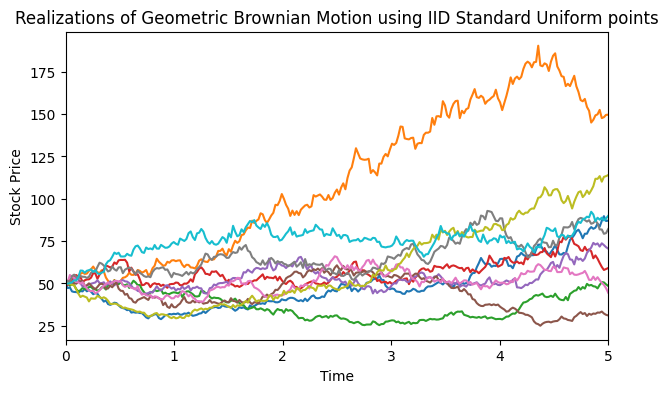

In [47]:
gbm_iid = qp.GeometricBrownianMotion(qp.IIDStdUniform(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2)
plot_gbm_paths(gbm_iid, n=10, title='Realizations of Geometric Brownian Motion using IID Standard Uniform points')

# GBM using low-discrepancy Lattice sequence distrubtion 

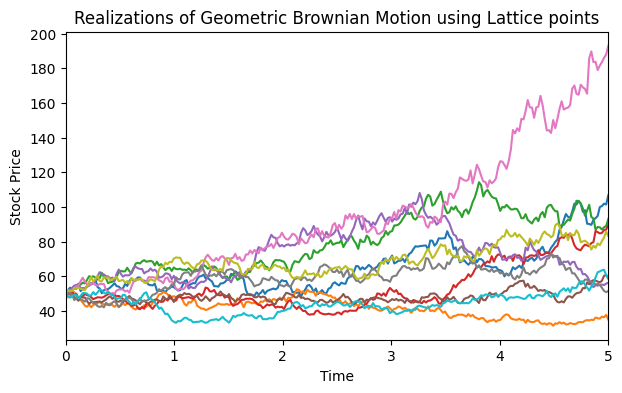

In [46]:
gbm_lattice = qp.GeometricBrownianMotion(qp.Lattice(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2)
plot_gbm_paths(gbm_lattice, n=10, title='Realizations of Geometric Brownian Motion using Lattice points')